## 2022-12-15: Accuracy of Polynomial Interpolation

*Last Updated*: 2023-01-10

### Authors
* Kevin Chu (kevin@velexi.com)


### Overview
This Jupyter notebook explores how the choice of interpolation method affects the accuracy of polynomial interpolation.

### Key Results

* Equispaced interpolation points are a very poor choice for high-order interpolation.

  * For noise-free data, interpolants are not guaranteed to converge as the degree of the polynomial is increased.
  
  * In the presence of noise, errors in the function values are amplified (with greater amplification for higher-degree polynomials).


* For high-order interpolation, Chebyshev interpolation points are a good choice (for both noise-free and noisy data).

  * When interpolation is implemented using Lagrange interpolation, round-off error start to degrade the accuracy of the interpolant for polynomial orders of intermediate size (e.g., 30).M

  * To avoid the round-off error introduced by Lagrange interpolation, interpolation should be implemented using the Discrete Cosine Transform (or an equivalent method based on fourier series).


* When low-order approximations are acceptable, spline interpolation is a reasonable option.

  * Using the Cauchy Interpolation Error Theorem [1], it seems possible to control the error of a spline approximation, but the convergence properties are weaker than for Chebyshev interpolation for the following reasons.
  
    * The interpolation grid spacing needs to be smaller than 1 (in the relevant units).
    
    * The convergence rate is a small power of the interpolation grid spacing (e.g., 4 for cubic splines).


* When the interpolation range is sufficiently narrow, equispaced interpolation points might be acceptable (i.e., yield interpolants that converge to the true function). Unfortunately, use of equispaced interpolation points suffers is discouraged for the following reasons.

    * In general, there is usually no way to know _a priori_ whether the interpolation range is sufficiently narrow.

    * Round-off error introduced by Lagrange interpolation can degrade the approximation if higher-order approximations are needed reach a desired level of accuracy.

  

### Methodology

* Three interpolation methods were explored:

  * polynomial interpolation with equispaced interpolation points,
  
  * polynomial interpolation with Chebyshev interpolation points, and
  
  * polynomial interpolation with cubic splines.

* Experiments were performed for the cases of noise-free and noisy data.

  * __Noise-Free Data__. The function to be interpolated is the Lorentzian:
    $f(x) = \frac{1}{1 + x^2}$

  * __Noisy Data__. The function to be interpolated is the constant function: $f(x) = 1$.

### References

1. J.P. Boyd. "Chebyshev and Fourier Spectral Methods" (2001).

### History

#### 2023-01-10

* Added experiment and results for equispaced interpolation points for an narrow interpolation range.

### Preparations

In [1]:
# --- Imports

# Standard library
import math
import random

# External packages
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy import interpolate
from scipy import fft

In [2]:
# --- Plotting Parameters

N_plot = 200

# Matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
})

### Interpolating Noise-Free Data

In [3]:
# --- Define exact function to interpolate

# Lorentzian
def lorentzian(x: np.array) -> np.array:
    """
    Return the value of the Lorentzian at the specified points `x`.
    
    Arguments
    ---------
    x: values to compute Lorentzian at
    """
    return 1 / (1 + x**2)

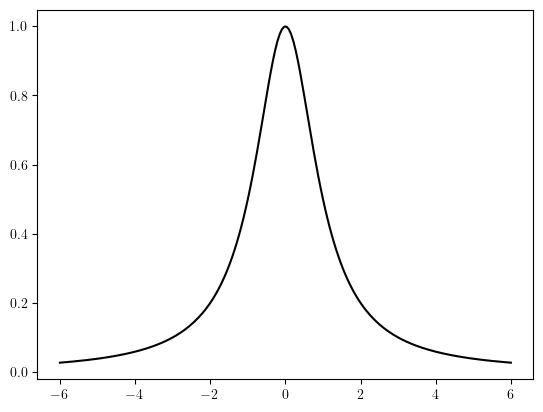

In [4]:
# --- Visual check of Lorentzian

# Plotting parameters
x_min = -6
x_max = 6
x = np.linspace(x_min, x_max, num=N_plot)

# Generate plot
plt.plot(x, lorentzian(x), 'k-')

plt.show()  # suppresses Matplotlib messages

#### Interpolation With Equispaced Points (on a Wide Interval)

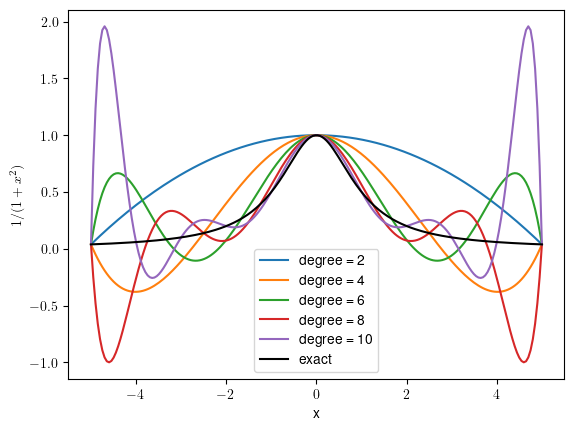

In [5]:
# --- Parameters

# Simulation parameters
x_max = 5
interpolant_degrees = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]

# --- Perform interpolation

# Initialize errors
errors = []

# Initialize figure
fig = plt.figure()
x_plot = np.linspace(-x_max, x_max, num=N_plot)

# Compute exact values at plotting points
y_exact = lorentzian(x_plot)

for degree in interpolant_degrees:

    # Generate interpolation points
    N = degree + 1
    x = np.linspace(-x_max, x_max, num=N)
    y = lorentzian(x)

    # Compute interpolating polynomial
    P = interpolate.lagrange(x, y)
    
    # Compute error of interpolant at plotting points
    y_interpolated = Polynomial(P.coef[::-1])(x_plot)
    errors.append(max(abs(y_interpolated - y_exact)))
    
    # Add plot of interpolating polynomial for degree ≤ 10
    if degree <= 10:
        plt.plot(x_plot, y_interpolated, label=f"degree = {degree}")
    
# Add plot of exact function
plt.plot(x_plot, y_exact, "k-", label="exact")

# Add figure decorators
plt.xlabel("x")
plt.ylabel(r"$1 / (1+x^2)$")
plt.legend()

plt.show()  # suppresses Matplotlib messages

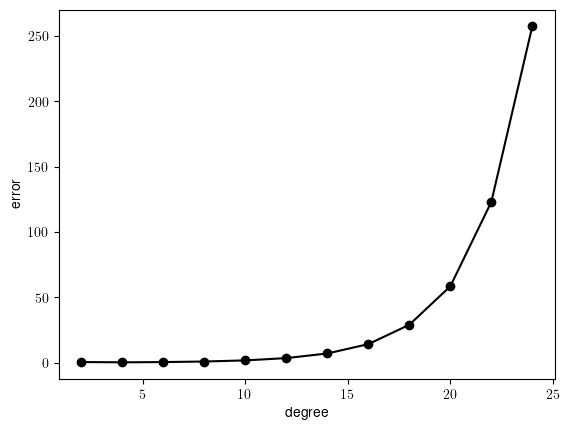

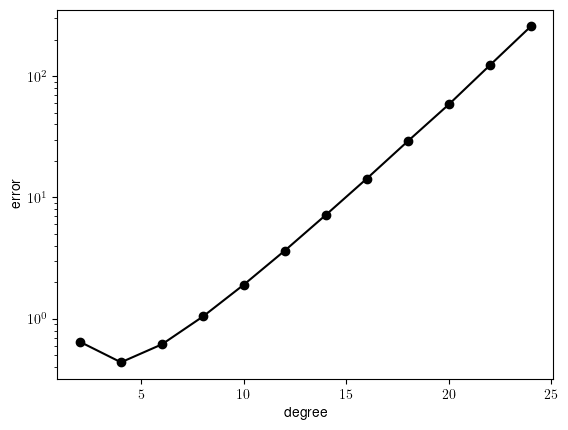

In [6]:
# --- Analyze errors

# Plot error as a function of interpolant degree
plt.figure()
plt.plot(interpolant_degrees, errors, "ko-")
plt.xlabel("degree")
plt.ylabel("error")

# Plot log-error as a function of interpolant degree
plt.figure()
plt.semilogy(interpolant_degrees, errors, "ko-")
plt.xlabel("degree")
plt.ylabel("error")

plt.show()  # suppresses Matplotlib messages

#### Interpolation With Chebyshev Points (using Lagrange Interpolation)

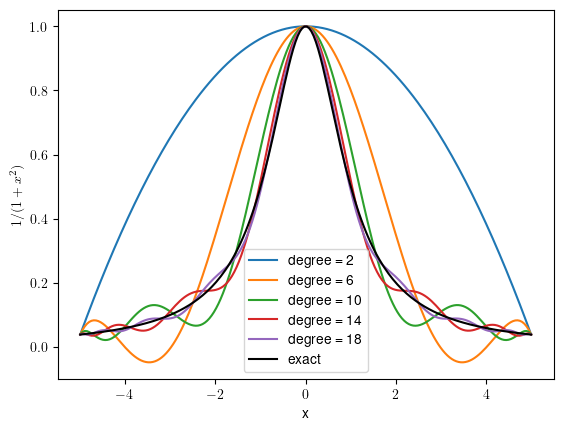

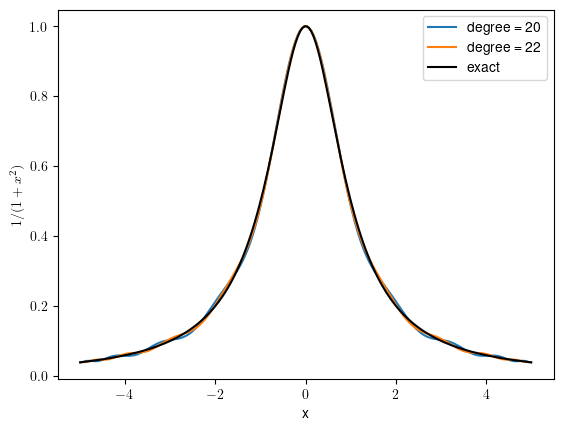

In [7]:
# --- Parameters

# Simulation parameters
x_max = 5
interpolant_degrees = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 40, 50]
plot_degrees = [2, 6, 10, 14, 18]

# --- Perform interpolation

# Initialize interpolants and errors
interpolants = {}
errors = []

# Initialize figure
fig = plt.figure()
x_plot = np.linspace(-x_max, x_max, num=N_plot)

# Compute exact values at plotting points
y_exact = lorentzian(x_plot)

for degree in interpolant_degrees:

    # Generate interpolation points
    N = degree + 1
    x = x_max * np.cos(np.linspace(0, math.pi, num=N))
    y = lorentzian(x)
    
    # Compute interpolating polynomial
    P = interpolate.lagrange(x, y)
    interpolants[degree] = P
    
    # Compute error of interpolant at plotting points
    y_interpolated = Polynomial(P.coef[::-1])(x_plot)
    errors.append(max(abs(y_interpolated - y_exact)))
    
    # Add plot of interpolating polynomial for specified degrees
    if degree in plot_degrees:
        plt.plot(x_plot, y_interpolated, label=f"degree = {degree}")
    
# Add plot of exact function
plt.plot(x_plot, y_exact, "k-", label="exact")

# Add figure decorators
plt.xlabel("x")
plt.ylabel(r"$1 / (1+x^2)$")
plt.legend()

# --- Add figure showing only a sampling of high-degree interpolants

plot_degrees = [20, 22]
plt.figure()
for degree in plot_degrees:
    y_interpolated = Polynomial(interpolants[degree].coef[::-1])(x_plot)
    plt.plot(x_plot, y_interpolated, label=f"degree = {degree}")

plt.plot(x_plot, y_exact, "k-", label="exact")
plt.xlabel("x")
plt.ylabel(r"$1 / (1+x^2)$")
plt.legend()

plt.show()  # suppresses Matplotlib messages

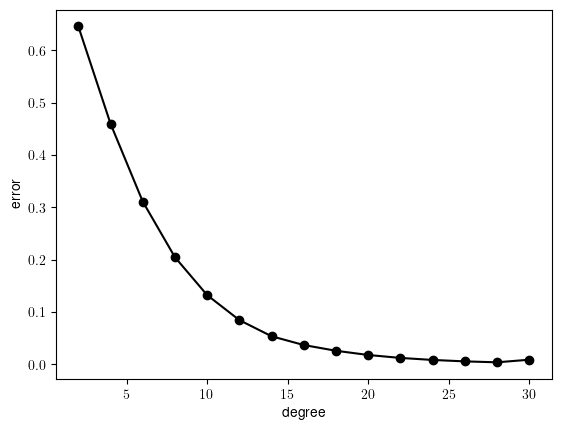

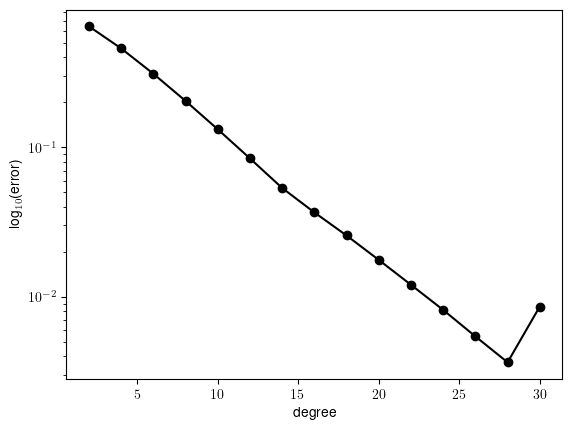

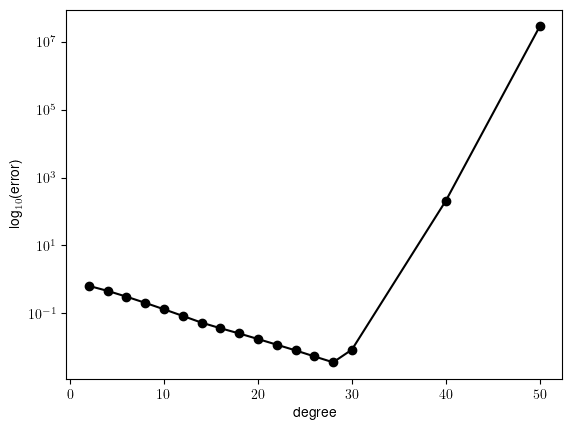

In [8]:
# --- Analyze errors

# Plot error as a function of interpolant degree (excluding largest degrees)
plt.figure()
degrees = [degree for degree in interpolant_degrees if degree < 40]
plt.plot(degrees, errors[0:len(degrees)], "ko-")
plt.xlabel("degree")
plt.ylabel("error")

# Plot log-error as a function of interpolant degree (excluding largest degrees)
plt.figure()
plt.semilogy(degrees, errors[0:len(degrees)], "ko-")
plt.xlabel("degree")
plt.ylabel("log$_{10}$(error)")

# Plot log-error as a function of interpolant degree (including all degrees)
plt.figure()
plt.semilogy(interpolant_degrees, errors, "ko-")
plt.xlabel("degree")
plt.ylabel("log$_{10}$(error)")

plt.show()  # suppresses Matplotlib messages

#### Interpolation With Chebyshev Points (using Discrete Cosine Transform)

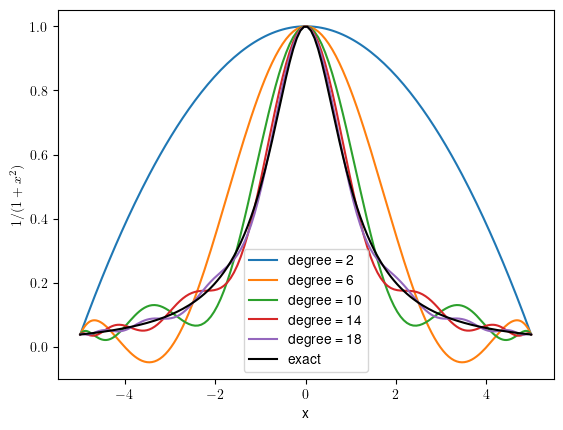

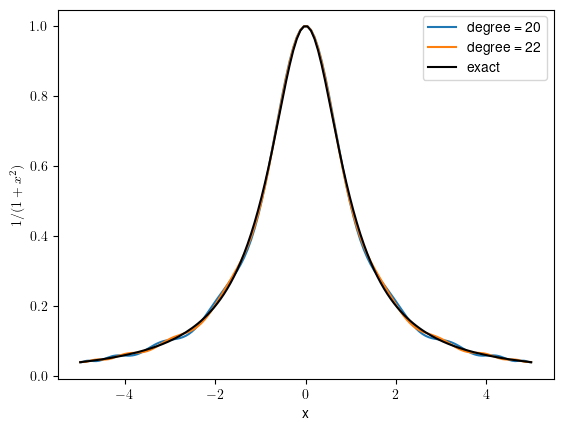

In [9]:
# --- Parameters

# Simulation parameters
x_max = 5
interpolant_degrees = [4]
plot_degrees = [4]
interpolant_degrees = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 40,
                       50, 100, 200, 300, 400]
plot_degrees = [2, 6, 10, 14, 18]

# --- Perform interpolation

# Initialize interpolants and errors
interpolants = {}
errors = []

# Initialize figure
fig = plt.figure()
theta_plot = np.linspace(0, math.pi, num=N_plot)
x_plot = x_max * np.cos(theta_plot)

# Compute exact values at plotting points
y_exact = lorentzian(x_plot)

for degree in interpolant_degrees:

    # Generate interpolation points
    N = degree + 1
    theta = np.linspace(0, math.pi, num=N, endpoint=True)
    y = lorentzian(x_max * np.cos(theta))
    
    # Compute interpolating polynomial via trigonometric interpolation in theta
    coefs = fft.dct(y, type=1, norm="forward")
    interpolants[degree] = coefs
    
    # Compute error of interpolant at plotting points
    cos_matrix = np.cos(
        np.tile(theta_plot, [N, 1]).T @ np.diag(np.cumsum(np.ones(N)) - 1)
    )
    cos_matrix[:,1:-1] *= 2
    y_interpolated = cos_matrix @ coefs
    errors.append(max(abs(y_interpolated - y_exact)))
    
    # Add plot of interpolating polynomial for specified degrees
    if degree in plot_degrees:
        x = x_max * np.cos(theta)
        plt.plot(x_plot, y_interpolated, label=f"degree = {degree}")
    
# Add plot of exact function
plt.plot(x_plot, y_exact, "k-", label="exact")

# Add figure decorators
plt.xlabel("x")
plt.ylabel(r"$1 / (1+x^2)$")
plt.legend()

# --- Add figure showing only a sampling of high-degree interpolants

plot_degrees = [20, 22]
plt.figure()
for degree in plot_degrees:
    N = degree + 1
    cos_matrix = np.cos(
        np.tile(theta_plot, [N, 1]).T @ np.diag(np.cumsum(np.ones(N)) - 1)
    )
    cos_matrix[:,1:-1] *= 2
    y_interpolated = cos_matrix @ interpolants[degree]
    plt.plot(x_plot, y_interpolated, label=f"degree = {degree}")

plt.plot(x_plot, y_exact, "k-", label="exact")
plt.xlabel("x")
plt.ylabel(r"$1 / (1+x^2)$")
plt.legend()

plt.show()  # suppresses Matplotlib messages

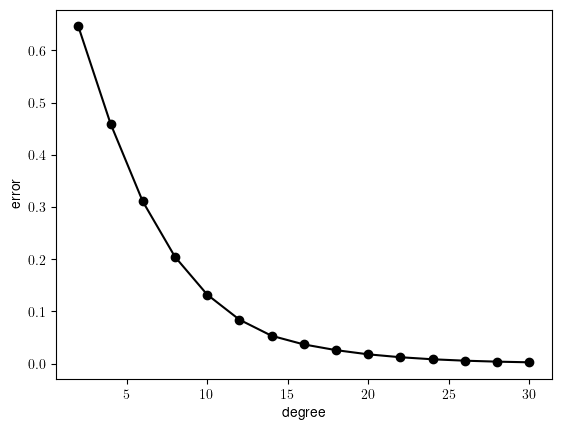

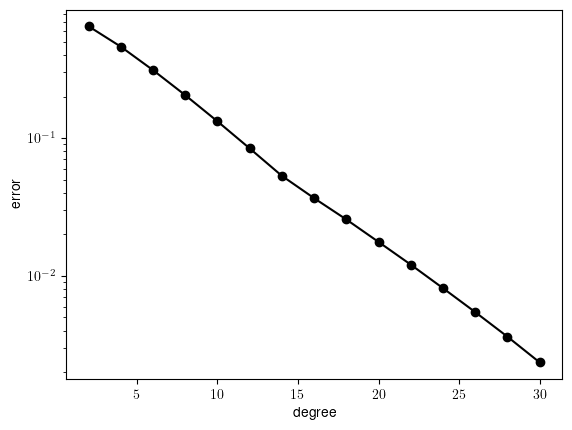

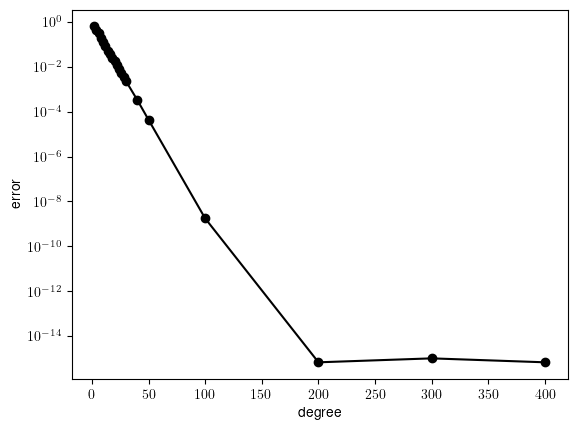

In [10]:
# --- Analyze errors

# Plot error as a function of interpolant degree (excluding largest degrees)
plt.figure()
degrees = [degree for degree in interpolant_degrees if degree < 40]
plt.plot(degrees, errors[0:len(degrees)], "ko-")
plt.xlabel("degree")
plt.ylabel("error")

# Plot log-error as a function of interpolant degree (excluding largest degrees)
plt.figure()
plt.semilogy(degrees, errors[0:len(degrees)], "ko-")
plt.xlabel("degree")
plt.ylabel("error")

# Plot log-error as a function of interpolant degree (including all degrees)
plt.figure()
plt.semilogy(interpolant_degrees, errors, "ko-")
plt.xlabel("degree")
plt.ylabel("error")

plt.show()  # suppresses Matplotlib messages

#### Interpolation With Splines

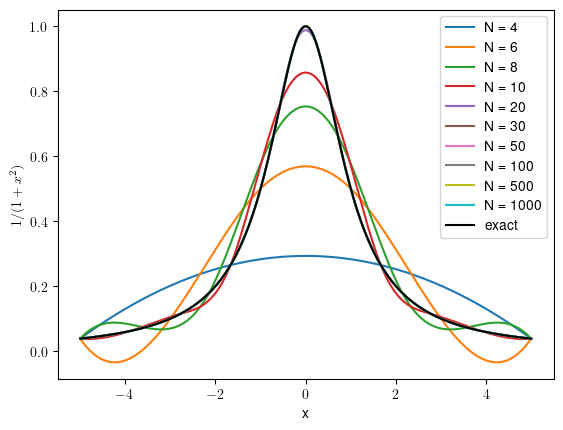

In [11]:
# --- Parameters

# Simulation parameters
x_max = 5
num_interpolation_points = [4, 6, 8, 10, 20, 30, 50, 100, 500, 1000]

# --- Perform interpolation

# Initialize errors
errors = []

# Initialize figure
fig = plt.figure()
x_plot = np.linspace(-x_max, x_max, num=N_plot)

# Compute exact values at plotting points
y_exact = lorentzian(x_plot)

for N in num_interpolation_points:
    # Generate interpolation points
    x = np.linspace(-x_max, x_max, num=N)
    y = lorentzian(x)

    # Compute cubic spline
    spline = interpolate.interp1d(x, y, kind="cubic")

    # Compute error of interpolant at plotting points
    y_interpolated = spline(x_plot)
    errors.append(max(abs(y_interpolated - y_exact)))

    # Add plot of spline
    plt.plot(x_plot, y_interpolated, label=f"N = {N}")

# Add plot of exact function
plt.plot(x_plot, y_exact, "k-", label="exact")

# Add figure decorators
plt.xlabel("x")
plt.ylabel(r"$1 / (1+x^2)$")
plt.legend()

plt.show()  # suppresses Matplotlib messages

'Maximum Error: 0.706'

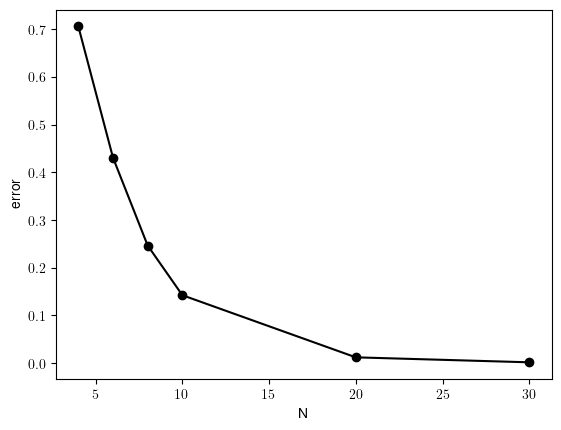

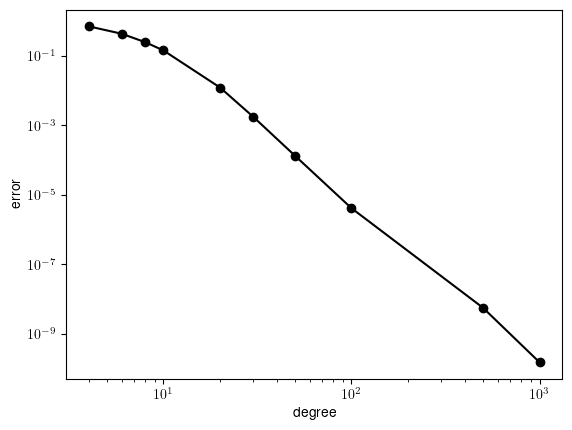

In [12]:
# --- Analyze errors

# Compute maximum error
max_error = max(abs(np.array(errors)))
display(
    f"Maximum Error: {max_error:0.3g}"
)

# Plot error as a function of N (excluding largest values)
plt.figure()
N_values = [N for N in num_interpolation_points if N < 50]
plt.plot(N_values, errors[0:len(N_values)], "ko-")
plt.xlabel("N")
plt.ylabel("error")

# Plot log-log plot as a function of N (including all degrees)
plt.figure()
plt.loglog(num_interpolation_points, errors, "ko-")
plt.xlabel("degree")
plt.ylabel("error")

plt.show()  # suppresses Matplotlib messages

In [13]:
# --- Predict magnitude of error from function and spline parameters

dy = y[1:] - y[0:-1]
d2y = dy[1:] - dy[0:-1]
d3y = d2y[1:] - d2y[0:-1]
d4y = d3y[1:] - d3y[0:-1]

dx = x[1:] - x[0:-1]
max_dx = max(abs(dx))

d4ydx4 = d4y / max_dx**4
max_d4ydx4 = max(abs(d4ydx4))

# Estimate error using Cauchy interpolation error theorem
error_estimate = max_d4ydx4 / 24 * max_dx**4 * (9 / 4)

display(f"Error Estimate: {error_estimate:0.3g}")

'Error Estimate: 2.26e-08'

#### Interpolation With Equispaced Points (on a Narrow Interval)

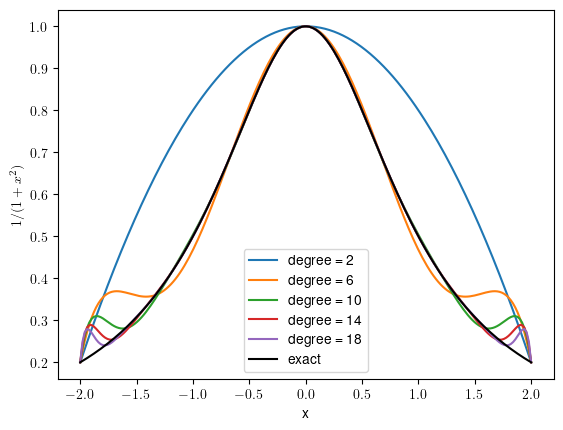

In [14]:

# --- Parameters

# Simulation parameters
x_max = 2
interpolant_degrees = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 40, 50]
plot_degrees = [2, 6, 10, 14, 18]

# --- Perform interpolation

# Initialize errors
errors = []

# Initialize figure
fig = plt.figure()
x_plot = np.linspace(-x_max, x_max, num=N_plot)

# Compute exact values at plotting points
y_exact = lorentzian(x_plot)

for degree in interpolant_degrees:

    # Generate interpolation points
    N = degree + 1
    x = np.linspace(-x_max, x_max, num=N)
    y = lorentzian(x)

    # Compute interpolating polynomial
    P = interpolate.lagrange(x, y)
    
    # Compute error of interpolant at plotting points
    y_interpolated = Polynomial(P.coef[::-1])(x_plot)
    errors.append(max(abs(y_interpolated - y_exact)))
    
    # Add plot of interpolating polynomial for specified degrees
    if degree in plot_degrees:
        plt.plot(x_plot, y_interpolated, label=f"degree = {degree}")

# Add plot of exact function
plt.plot(x_plot, y_exact, "k-", label="exact")

# Add figure decorators
plt.xlabel("x")
plt.ylabel(r"$1 / (1+x^2)$")
plt.legend()

plt.show()  # suppresses Matplotlib messages

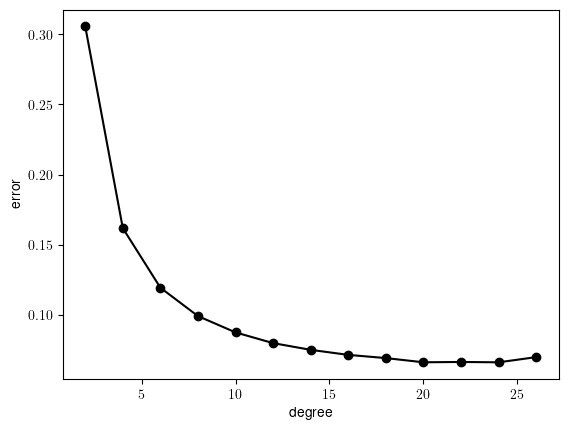

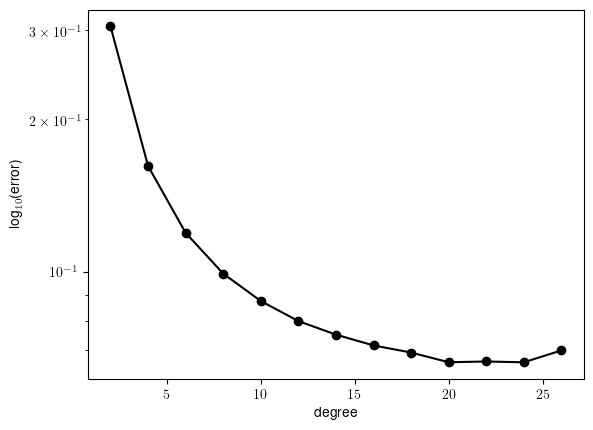

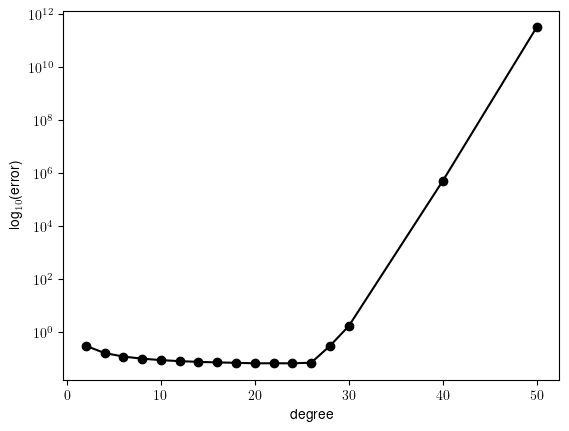

In [15]:
# --- Analyze errors

# Plot error as a function of interpolant degree (excluding largest degrees)
plt.figure()
degrees = [degree for degree in interpolant_degrees if degree < 28]
plt.plot(degrees, errors[0:len(degrees)], "ko-")
plt.xlabel("degree")
plt.ylabel("error")

# Plot log-error as a function of interpolant degree (excluding largest degrees)
plt.figure()
plt.semilogy(degrees, errors[0:len(degrees)], "ko-")
plt.xlabel("degree")
plt.ylabel("log$_{10}$(error)")

# Plot log-error as a function of interpolant degree (including all degrees)
plt.figure()
plt.semilogy(interpolant_degrees, errors, "ko-")
plt.xlabel("degree")
plt.ylabel("log$_{10}$(error)")

plt.show()  # suppresses Matplotlib messages

### Interpolating Noisy Data

In [16]:
# --- Define exact function to interpolate

# Constant function
def f_constant(x: np.array) -> np.array:
    """
    Return the value of the Lorentzian at the specified points `x`.
    
    Arguments
    ---------
    x: values to compute Lorentzian at
    """
    return np.ones(x.shape)

#### Interpolation With Equispaced Points

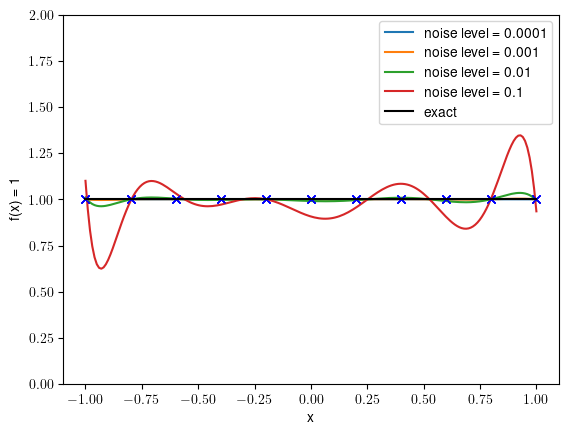

In [17]:
# --- Parameters

# Simulation parameters
x_max = 1
degree = 10

noise_levels = [1e-4, 0.001, 0.01, 0.1]

# --- Perform interpolation

# Initialize errors
errors = []

# Initialize figure
fig = plt.figure()
x_plot = np.linspace(-x_max, x_max, num=N_plot)

# Compute exact values at plotting points
y_exact = f_constant(x_plot)

# Compute interpolation points
N = degree + 1
x = np.linspace(-x_max, x_max, num=N)

# Generate noise ensuring that at least one value is O(1)
noise = np.random.uniform(-1, 1, size=x.shape)
noise[0] = 1
    
for noise_level in noise_levels:

    # Generate interpolation values
    y_without_noise = f_constant(x)
    y_with_noise = y_without_noise + noise_level * noise

    # Compute interpolating polynomial
    P = interpolate.lagrange(x, y_with_noise)
    
    # Compute error of interpolant at plotting points
    y_interpolated = Polynomial(P.coef[::-1])(x_plot)
    errors.append(max(abs(y_interpolated - y_exact)))
    
    # Add plot of interpolating polynomials
    plt.plot(x_plot, y_interpolated, label=f"noise level = {noise_level}")
    plt.plot(x, y_without_noise, "bx")
    
# Add plot of exact function
plt.plot(x_plot, y_exact, "k-", label="exact")

# Add figure decorators
plt.xlabel("x")
plt.ylabel("f(x) = 1")
plt.ylim([0, 2])
plt.legend()

plt.show()  # suppresses Matplotlib messages

'Maximum Error (for noise level = 0.1): 0.375'

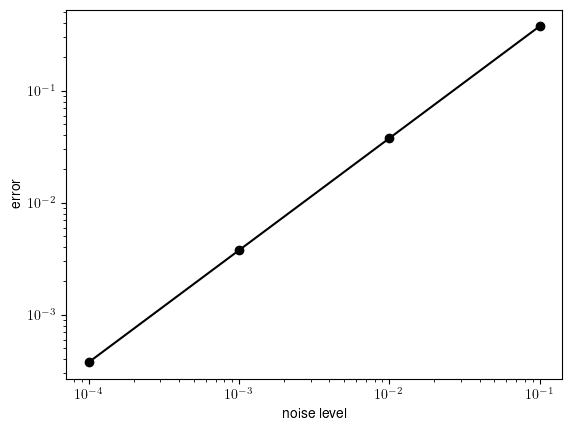

In [18]:
# --- Analyze errors

# Compute maximum error
max_error = max(abs(np.array(errors)))
display(
    f"Maximum Error (for noise level = {noise_levels[-1]}): {max_error:0.3g}"
)

# Plot error as a function of interpolant degree (excluding largest degrees)
plt.figure()
plt.loglog(noise_levels, errors, "ko-")
plt.xlabel("noise level")
plt.ylabel("error")

plt.show()  # suppresses Matplotlib messages

#### Interpolation With Chebyshev Points (using Discrete Cosine Transform)

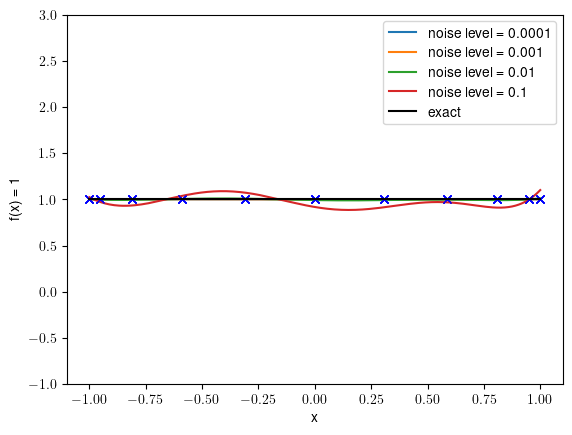

In [19]:
# --- Parameters

# Simulation parameters
x_max = 1
degree = 10

noise_levels = [1e-4, 0.001, 0.01, 0.1]

# --- Perform interpolation

# Initialize errors
errors = []

# Initialize figure
fig = plt.figure()
theta_plot = np.linspace(0, math.pi, num=N_plot)
x_plot = x_max * np.cos(theta_plot)

# Compute exact values at plotting points
y_exact = f_constant(x_plot)

# Compute interpolation points
N = degree + 1
theta = np.linspace(0, math.pi, num=N, endpoint=True)
x = x_max * np.cos(theta)

# Generate noise ensuring that at least one value is O(1)
noise = np.random.uniform(-1, 1, size=x.shape)
noise[0] = 1

for noise_level in noise_levels:

    # Generate interpolation values
    y_without_noise = f_constant(x)
    y_with_noise = y_without_noise + noise_level * noise
    
    # Compute interpolating polynomial via trigonometric interpolation in theta
    coefs = fft.dct(y_with_noise, type=1, norm="forward")
    interpolants[noise_level] = coefs
    
    # Compute error of interpolant at plotting points
    cos_matrix = np.cos(
        np.tile(theta_plot, [N, 1]).T @ np.diag(np.cumsum(np.ones(N)) - 1)
    )
    cos_matrix[:,1:-1] *= 2
    y_interpolated = cos_matrix @ coefs
    errors.append(max(abs(y_interpolated - y_exact)))

    # Add plot of interpolating polynomials
    plt.plot(x_plot, y_interpolated, label=f"noise level = {noise_level}")
    plt.plot(x, y_without_noise, "bx")
    
# Add plot of exact function
plt.plot(x_plot, y_exact, "k-", label="exact")

# Add figure decorators
plt.xlabel("x")
plt.ylabel("f(x) = 1")
plt.ylim([-1, 3])
plt.legend()

plt.show()  # suppresses Matplotlib messages

'Maximum Error (for noise level = 0.1): 0.115'

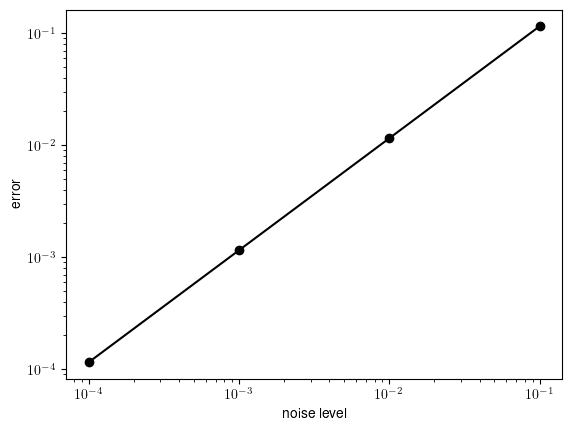

In [20]:
# --- Analyze errors

# Compute maximum error
max_error = max(abs(np.array(errors)))
display(
    f"Maximum Error (for noise level = {noise_levels[-1]}): {max_error:0.3g}"
)

# Plot error as a function of interpolant degree (excluding largest degrees)
plt.figure()
plt.loglog(noise_levels, errors, "ko-")
plt.xlabel("noise level")
plt.ylabel("error")

plt.show()  # suppresses Matplotlib messages